In [1]:
import os
import sys
from scipy import stats
import itertools
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, ShuffleSplit
from tqdm import tqdm
import warnings
import matplotlib as mpl
import plot_utils

from string import ascii_lowercase as abc
abc = [*abc] + [f'{l}2' for l in abc]

warnings.filterwarnings('ignore', 'invalid value encountered in true_divide')

## Settings

In [2]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [3]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [4]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

## Colors

In [5]:
ot1_color = 'tab:green'
palette_tcrs = {'OT1': ot1_color, 
                'OTI': ot1_color, 
                'Educated': 'tab:orange',
                'Naive': 'tab:blue', 
                'Human': 'Firebrick'
               }

palette_educated = sb.color_palette('Oranges', 16)[:8]
palette_naive_test = 'Blues'
palette_naive_ot1 = 'Greens'
palette_human = sb.color_palette('Reds', 16)[8-1:]

color_greedy = 'silver'
color_active = 'tab:orange'
color_random = 'grey'
color_human = palette_tcrs['Human']

In [6]:
palette_pos = ['silver'] + sb.color_palette('deep', 11)[2:]
palette_pos = dict(zip(['-', 1, 2, 3, 4, 5, 6, 7, 8, 9], palette_pos))

## Load data

In [7]:
def load_experiment(filename):
    path_exp = f'../activation-prediction/results/active_learning/{filename}'
    with open(path_exp) as f:
        results_exp = json.load(f)
    return results_exp

In [8]:
def load_greedy(folder, metric='auc'):
    path_exp = f'../activation-prediction/results/active_learning/{folder}/'
    res_files = [path_exp + f for f in os.listdir(path_exp) if os.path.isfile(os.path.join(path_exp, f))]
    res_files = [f for f in res_files if metric in f]

    results_upper = {}
    
    for path_file in res_files:
        with open(path_file) as f:
            res_tmp = json.load(f)
        for mtc, vals in res_tmp.items():
            if mtc not in results_upper:
                results_upper[mtc] = []
            if len(vals[0])==3:
                vals = [val[0:1] + ['True'] + val[1:] for val in vals]
            results_upper[mtc] += vals
    return results_upper

In [9]:
results_within_mice = {
    'Active': load_experiment('within/SIINFEKL_FULL_act_avg_8.json'),
    'Random': load_experiment('within/SIINFEKL_FULL_rdm_8.json'),
    'Greedy_auc': load_greedy('within/greedy/SIINFEKL'),
    'Greedy_spearman': load_greedy('within/greedy/SIINFEKL', metric='spearman'),
}
results_within_human = {
    'Active': load_experiment('within/VPSVWRSSL_FULL_act_avg_8.json'),
    'Random': load_experiment('within/VPSVWRSSL_FULL_rdm_8.json'),
    'Greedy_auc': load_greedy('within/greedy/VPSVWRSSL'),
    'Greedy_spearman': load_greedy('within/greedy/VPSVWRSSL', metric='spearman'),
}

In [10]:
results_across_mice = {
    'Active': load_experiment('across/SIINFEKL_crossTCR_FULL_active_8_10.json'),
    'Random': load_experiment('across/SIINFEKL_crossTCR_FULL_random_8_10.json'),
    'Greedy_auc': load_greedy('across/greedy/SIINFEKL'),
    'Greedy_spearman': load_greedy('across/greedy/SIINFEKL', metric='spearman'),
}
results_across_human = {
    'Active': load_experiment('across/VPSVWRSSL_crossTCR_FULL_active_8_10.json'),
    'Random': load_experiment('across/VPSVWRSSL_crossTCR_FULL_random_8_10.json'),
    'Greedy_auc': load_greedy('across/greedy/VPSVWRSSL'),
    'Greedy_spearman': load_greedy('across/greedy/VPSVWRSSL', metric='spearman'),
}

In [11]:
def get_mutation(apl, base):
    for i, (l1, l2) in enumerate(zip(apl, base)):
        if l1 != l2:
            return i+1, l1
    return '-', 'None'
    
def load_used_apls(filename):
    path_apls = f'../activation-prediction/results/active_learning/{filename}'
    base_epitope = 'SIINFEKL' if 'SIINFEKL' in filename else 'VPSVWRSSL'
    
    df_apls = pd.read_csv(path_apls, skiprows = 1,header = None)
    columns = ['seed', 'tcr'] + list(range(1, len(df_apls.columns)-1))
    df_apls.columns = columns
    df_apls[1] = df_apls[1].str[1:]
    df_apls[columns[-1]] = df_apls[columns[-1]].str[:-1]
    
    if 'within' in filename:
        df_apls = df_apls[['seed', 'tcr'] + list(range(1, 81))]
    else:
        df_apls = df_apls[['seed', 'tcr'] + list(range(1, 80))]
    
    for col in df_apls.columns:
        if col in ['seed', 'tcr']:
            continue
        df_apls[col] = df_apls[col].str.strip().str[1:-1]
        df_apls[f'pos_{col}'], df_apls[f'aa_{col}'] = zip(*df_apls[col].apply(lambda x: get_mutation(x, base_epitope)))        
    return df_apls

In [12]:
apls_within_mice = {
    'Active': load_used_apls('within/SIINFEKL_selectedAPLs_add_by_uncertainty_clf_avg.csv'),
    'Random': load_used_apls('within/SIINFEKL_selectedAPLs_add_by_random.csv'),
    'Greedy_auc': load_used_apls('within/SIINFEKL_selectedAPLs_greedy_auc.csv'),
    'Greedy_spearman': load_used_apls('within/SIINFEKL_selectedAPLs_greedy_spearman.csv'),
}
apls_within_human = {
    'Active': load_used_apls('within/VPSVWRSSL_selectedAPLs_add_by_uncertainty_clf_avg.csv'),
    'Random': load_used_apls('within/VPSVWRSSL_selectedAPLs_add_by_random.csv'),
    'Greedy_auc': load_used_apls('within/VPSVWRSSL_selectedAPLs_greedy_auc.csv'),
    'Greedy_spearman': load_used_apls('within/VPSVWRSSL_selectedAPLs_greedy_spearman.csv'),
}

In [13]:
apls_across_mice = {
    'Active': load_used_apls('across/SIINFEKL_selectedAPLs_add_active.csv'),
    'Random': load_used_apls('across/SIINFEKL_selectedAPLs_add_random.csv'),
    'Greedy_auc': load_used_apls('across/SIINFEKL_selectedAPLs_greedy_auc.csv'),
    'Greedy_spearman': load_used_apls('across/SIINFEKL_selectedAPLs_greedy_spearman.csv'),
}
apls_across_human = {
    'Active': load_used_apls('across/VPSVWRSSL_selectedAPLs_add_active.csv'),
    'Random': load_used_apls('across/VPSVWRSSL_selectedAPLs_add_random.csv'),
    'Greedy_auc': load_used_apls('across/VPSVWRSSL_selectedAPLs_greedy_auc.csv'),
    'Greedy_spearman': load_used_apls('across/VPSVWRSSL_selectedAPLs_greedy_spearman.csv'),
}

## Plotting function

In [14]:
def plot_performance(data, metric, methods, ax=None, xticks=None, legend=False, active_color=None):
    dfs_results = []
    for method in methods:
        df = pd.DataFrame(data[method][metric])
        columns = ['tcr', 'educated', 'iteration', metric] if len(df.columns) == 4 else ['tcr', 'iteration', metric]
        df.columns = columns
        df['method'] = method
        dfs_results.append(df)
    df_joint = pd.concat(dfs_results)
    
    
    colors = {
        'Greedy_auc': color_greedy,
        'Greedy_spearman': color_greedy,
        'Active': color_active if active_color is None else active_color,
        'Random': color_random,
    }
    
    plot = sb.lineplot(data=df_joint, x='iteration', y=metric, hue='method', ax=ax, palette=colors)


    sb.despine(bottom=False, left=False)

    plot.set_xlabel('Training Samples', labelpad=1)
    plot.set_ylabel(metric.upper() if len(metric)<4 else metric, labelpad=1)
    

    if legend:
        ax.legend(['Active', 'Random', 'Greedy'], title=None, bbox_to_anchor=(1, 1.25), 
                  loc="upper center", ncol=3, frameon=False)
    else:
        ax.get_legend().remove()
    plot.set_xticks(list(range(len(xticks))))
    plot.set_xticklabels(xticks)
    
    ax.tick_params(axis='both', which='major', pad=-2)
    
    ax.grid(False)
    sb.despine(ax=ax)

In [15]:
def plot_used_apls(df_apl, group='pos', groups=None, title='', ax=None, legend=False, xticks=None):
    df_tmp = df_apl[[col for col in df_apl.columns if str(col).startswith(group)]]
    df_tmp = df_tmp.apply(lambda x: x.value_counts())
    df_tmp = df_tmp.fillna(0)
    df_tmp = df_tmp.transpose()
    
    if groups is not None:
        df_tmp['groups'] = groups
        df_tmp = df_tmp.groupby('groups').sum()
        df_tmp = df_tmp.div(df_tmp.sum(axis=1), axis=0)
        
    df_tmp.plot(kind='bar', stacked=True, color=palette_pos, ax=ax)
    ax.set_title(title, pad=0)
    ax.set_xlabel('Iteration', labelpad=1)
    ax.set_ylabel('Positions', labelpad=1)
    ax.set_xticklabels([el//8 for el in xticks], rotation=0)
    
    ax.tick_params(axis='both', which='major', pad=-2)
    
    if not legend:
        ax.get_legend().remove()
    else:
        ax.legend(bbox_to_anchor=(1, 1.15), loc="upper center", ncol=9, frameon=False)
    ax.grid(False)
    sb.despine(ax=ax)
    return df_tmp

In [16]:
def plot_legend(ax):
    legend_elements = [mpl.patches.Patch(facecolor=color, edgecolor=color, label=name)
                      for name, color in palette_pos.items()]
    ax.legend(handles=legend_elements, ncol=1, loc='right', title='Position')
    ax.grid(False)
    sb.despine(ax=ax, bottom=True, left=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

## Figure 6

<ipython-input-17-ccf9203e8c6d>:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


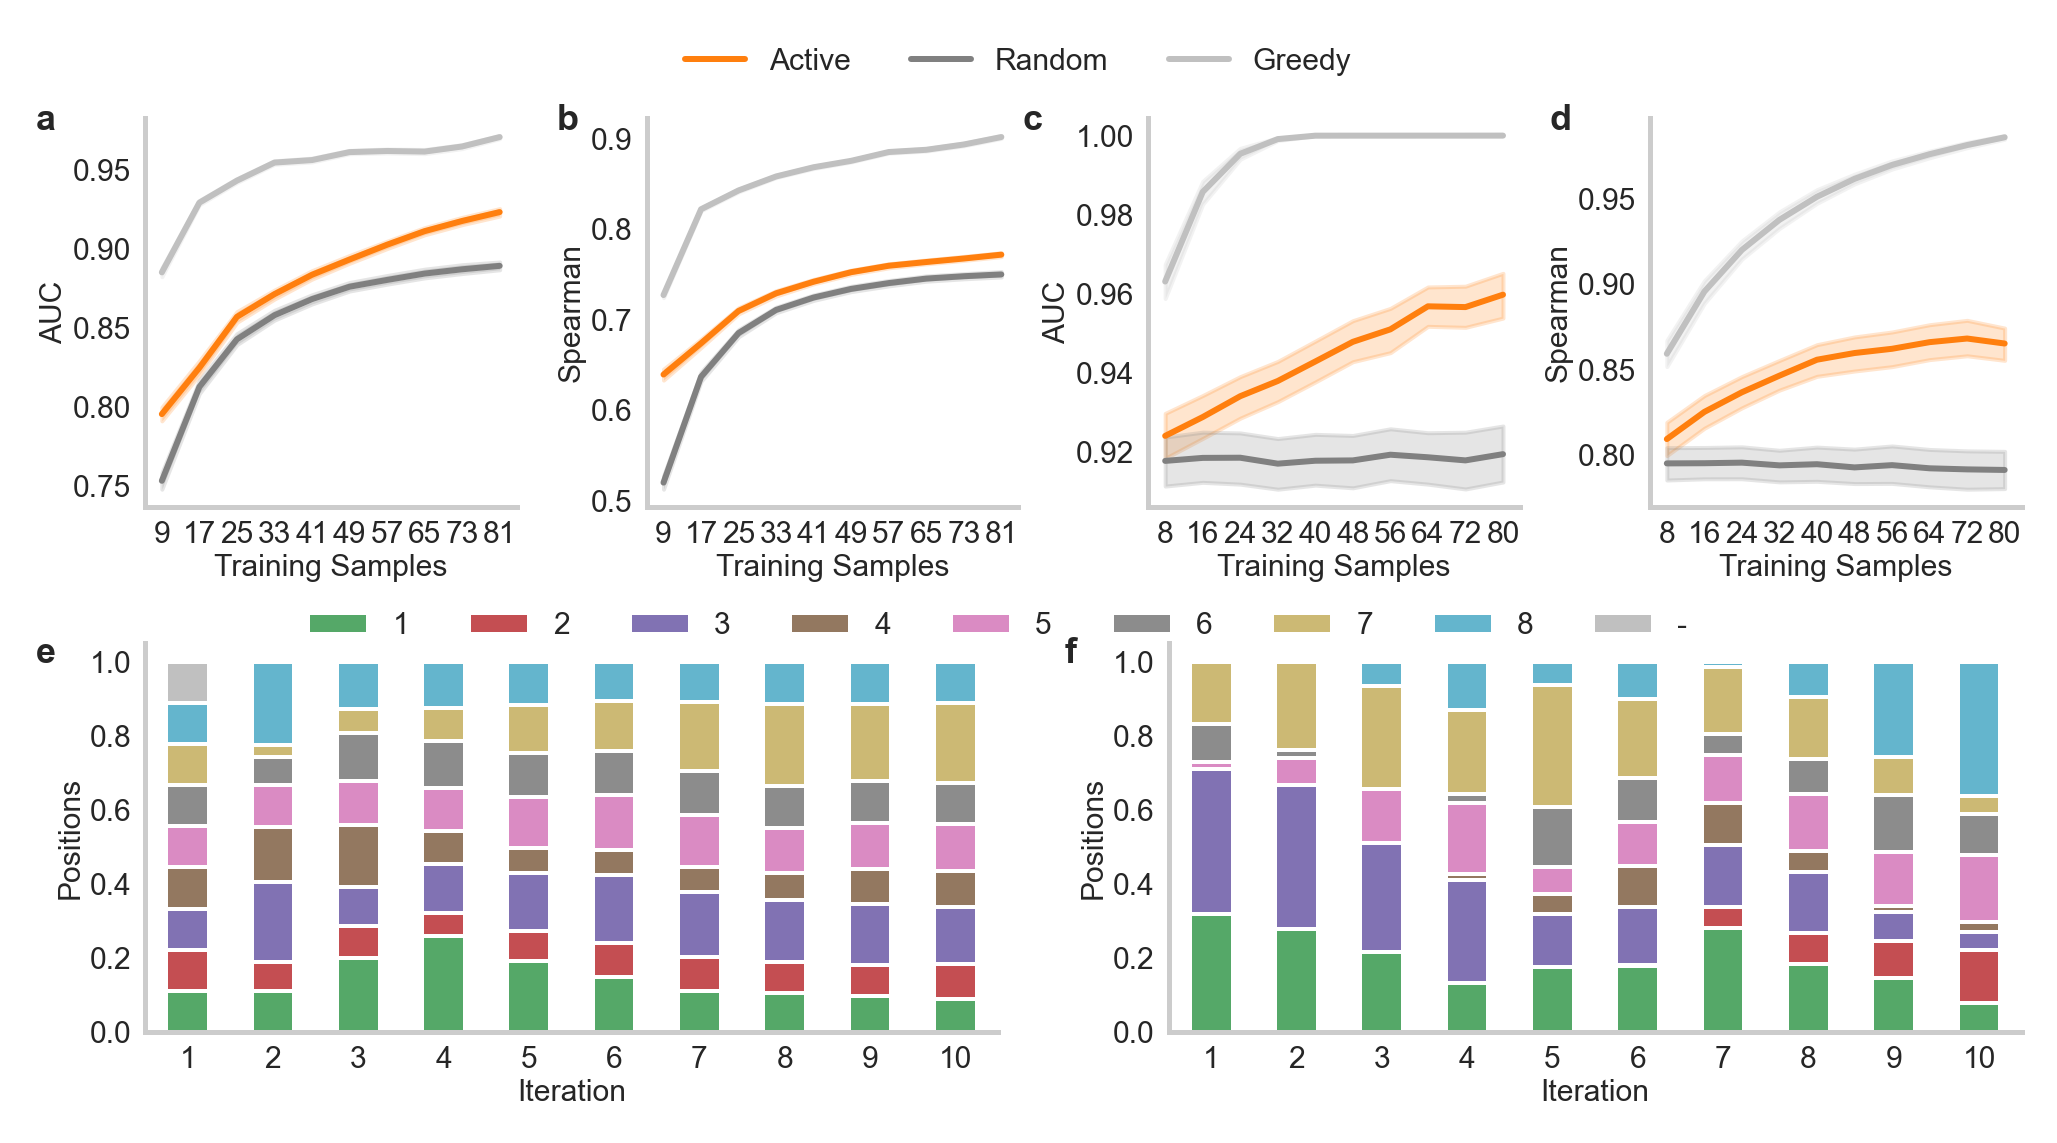

In [17]:
# auc within mice     spr across mice 
#      APLs               APLs
# active - greedy     active - greedy

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.5), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_full'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    hspace=0.35,
    height_ratios=[3, 3],
)

gridspecs['gs1-4'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_full'][0],
    nrows=1,
    ncols=4,
    wspace=0.35,
    width_ratios=[1, 1, 1, 1],
)
gridspecs['gs5-6'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs_full'][1],
    nrows=1,
    ncols=2,
    height_ratios=[1],
    hspace=0.45,
    width_ratios=[1, 1],
)

axes['ax_1'] = fig.add_subplot(gridspecs['gs1-4'][0])
axes['ax_2'] = fig.add_subplot(gridspecs['gs1-4'][1])
axes['ax_3'] = fig.add_subplot(gridspecs['gs1-4'][2])
axes['ax_4'] = fig.add_subplot(gridspecs['gs1-4'][3])

axes['ax_5'] = fig.add_subplot(gridspecs['gs5-6'][0])
axes['ax_6'] = fig.add_subplot(gridspecs['gs5-6'][1])

groups = [0] + [i//8 for i in range(79)]
xticks = [9+8*i for i in range(10)]
plot_performance(results_within_mice, 'auc', ['Active', 'Random', 'Greedy_auc'], ax=axes['ax_1'], xticks=xticks)
plot_performance(results_within_mice, 'Spearman', ['Active', 'Random', 'Greedy_spearman'], ax=axes['ax_2'], xticks=xticks, 
                 legend=True)

plot_used_apls(apls_within_mice['Active'], groups=groups,ax=axes['ax_5'], xticks=xticks, title=None, legend=True)


groups = [i//8 for i in range(79)]
xticks = [8+8*i for i in range(10)]
plot_performance(results_across_mice, 'auc', ['Active', 'Random', 'Greedy_auc'], ax=axes['ax_3'], xticks=xticks)
plot_performance(results_across_mice, 'Spearman', ['Active', 'Random', 'Greedy_spearman'], ax=axes['ax_4'], xticks=xticks)
plot_used_apls(apls_across_mice['Active'], groups=groups, ax=axes['ax_6'], xticks=xticks, title=None)


fig.text(0.08, 0.87, 'a', size='large', weight='bold')
fig.text(0.295, 0.87, 'b', size='large', weight='bold')
fig.text(0.4875, 0.87, 'c', size='large', weight='bold')
fig.text(0.705, 0.87, 'd', size='large', weight='bold')
fig.text(0.08, 0.43, 'e', size='large', weight='bold')
fig.text(0.505, 0.43, 'f', size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_fig6_active.pdf', dpi=DPI, bbox_inches='tight')

## Supplementary Figure 6

<ipython-input-18-caae0707fe0f>:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


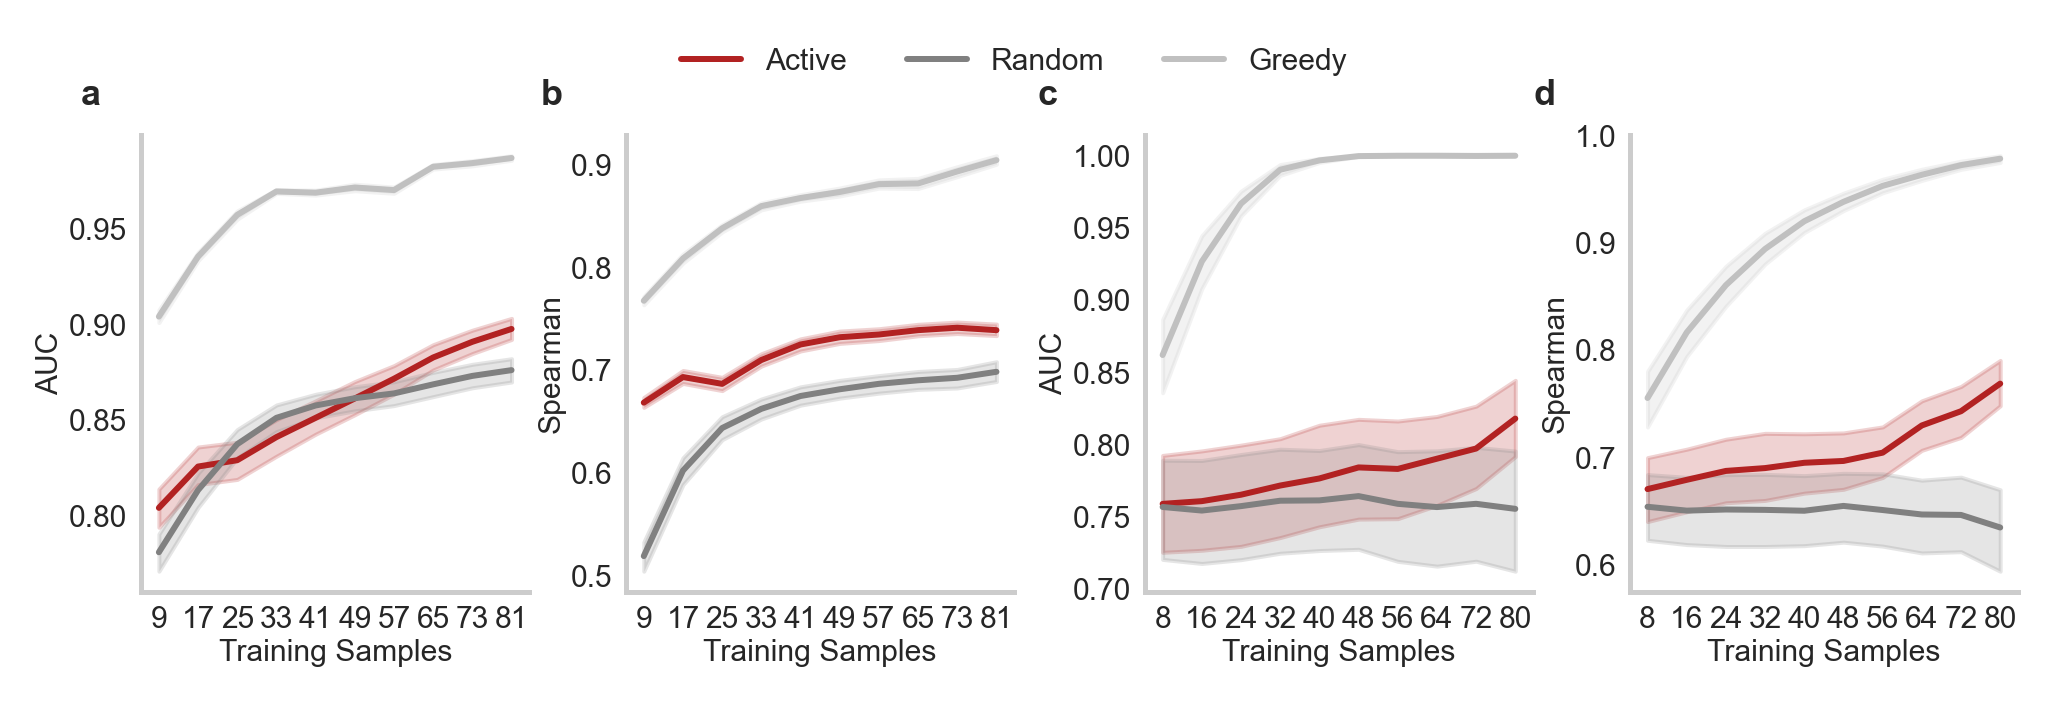

In [18]:
# auc within mice   within human   across mice   across human     
# spr within mice   within human   across mice   across human

fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.25), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs1-4'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[1, 1],
    wspace=0.15,
    height_ratios=[1],
)
gridspecs['gs12'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs1-4'][0],
    nrows=1,
    ncols=2,
    wspace=0.25,
    width_ratios=[1, 1],
)
gridspecs['gs34'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gridspecs['gs1-4'][1],
    nrows=1,
    ncols=2,
    wspace=0.25,
    width_ratios=[1, 1],
)



axes[f'ax_1'] = fig.add_subplot(gridspecs['gs12'][0])
axes[f'ax_2'] = fig.add_subplot(gridspecs['gs12'][1])
axes[f'ax_3'] = fig.add_subplot(gridspecs['gs34'][0])
axes[f'ax_4'] = fig.add_subplot(gridspecs['gs34'][1])

xticks = [9+8*i for i in range(10)]
plot_performance(results_within_human, 'auc', ['Active', 'Random', 'Greedy_auc'], ax=axes['ax_1'], xticks=xticks, 
                 active_color=color_human)
plot_performance(results_within_human, 'Spearman', ['Active', 'Random', 'Greedy_spearman'], ax=axes['ax_2'], xticks=xticks,
                active_color=color_human, legend=True)

xticks = [8+8*i for i in range(10)]
plot_performance(results_across_human, 'auc', ['Active', 'Random', 'Greedy_auc'], ax=axes['ax_3'], xticks=xticks,
                active_color=color_human)
plot_performance(results_across_human, 'Spearman', ['Active', 'Random', 'Greedy_spearman'], ax=axes['ax_4'], xticks=xticks,
                active_color=color_human)


fig.text(0.10, 0.93, 'a', size='large', weight='bold')
fig.text(0.29, 0.93, 'b', size='large', weight='bold')
fig.text(0.495, 0.93, 'c', size='large', weight='bold')
fig.text(0.70, 0.93, 'd', size='large', weight='bold')

    
fig.tight_layout()
fig.savefig('figures/manuscript_sfig7_active_human.pdf', dpi=DPI, bbox_inches='tight')

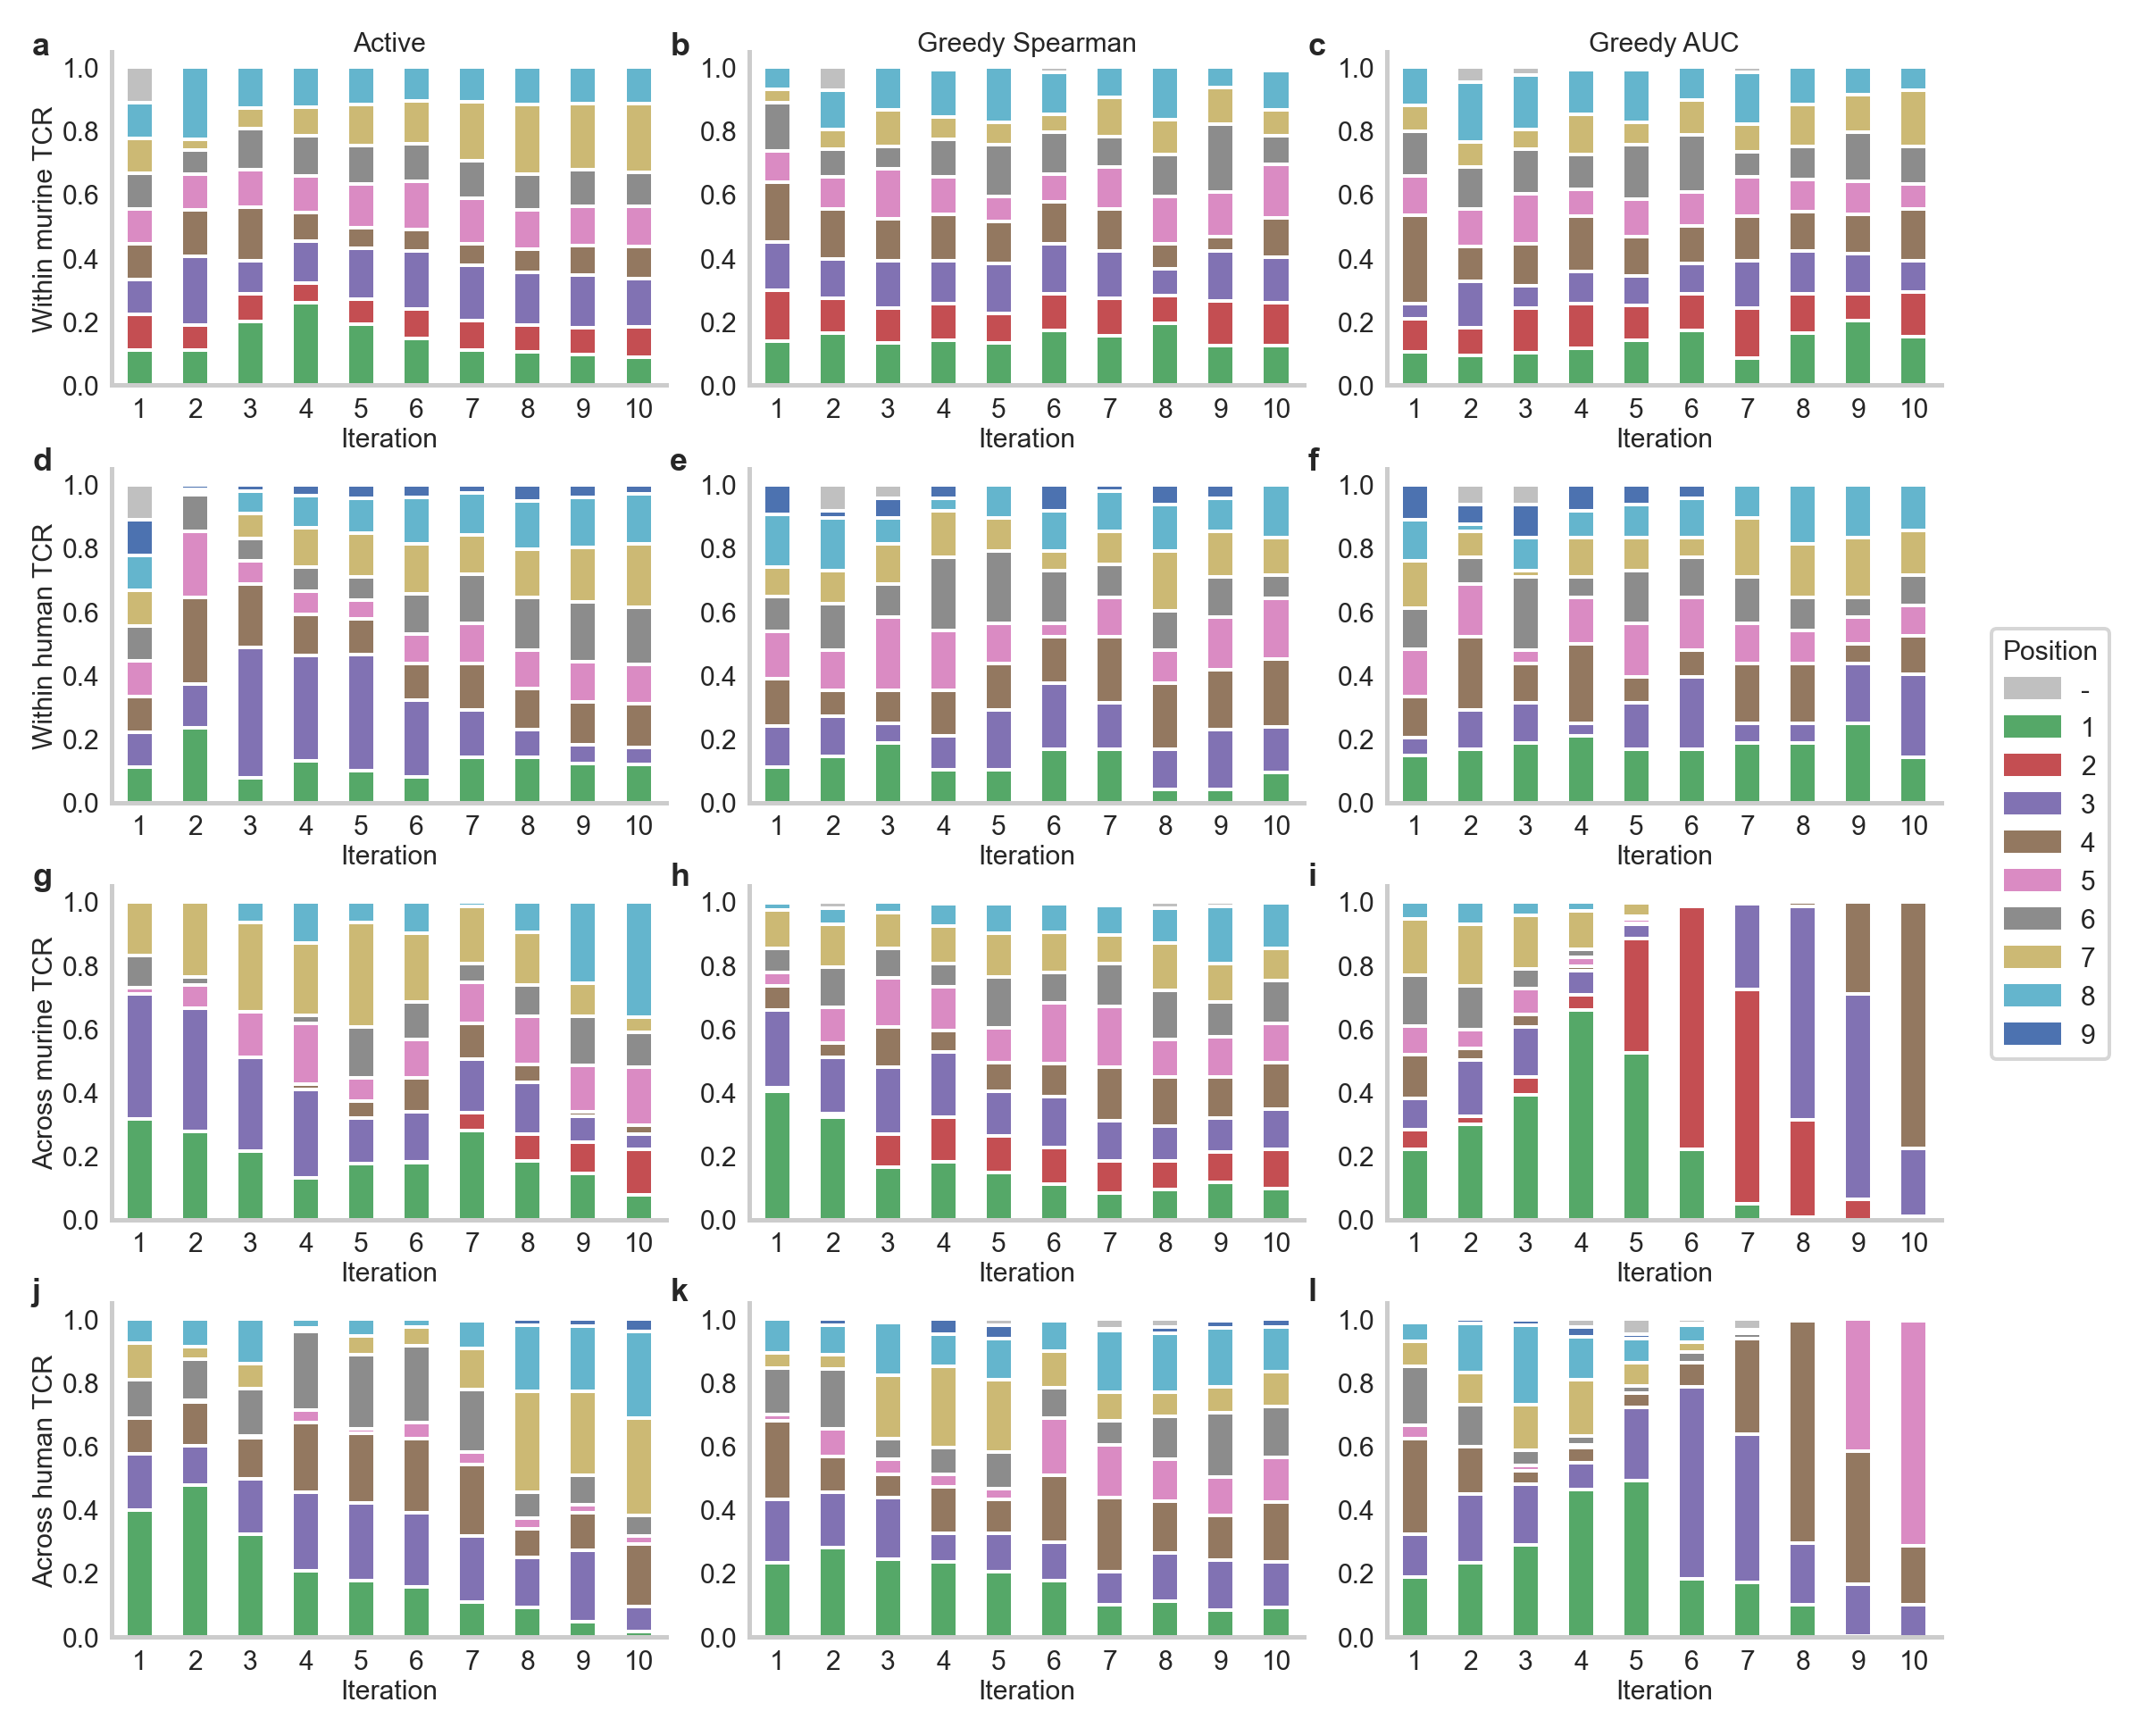

In [19]:
set_font_size(6)
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH*0.8), dpi=DPI)
gridspecs = {}
axes = {}

gridspecs['gs_full'] = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[18, 1]
)
    
gridspecs['gs1-12'] = mpl.gridspec.GridSpecFromSubplotSpec(   
    subplot_spec=gridspecs['gs_full'][0],
    nrows=4,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1, 1],
    wspace=0.15,
    hspace=0.25
)

axes['legend'] = fig.add_subplot(gridspecs['gs_full'][1])

for i in range(12):
    axes[f'ax_{i}'] = fig.add_subplot(gridspecs['gs1-12'][i])

xticks = [9+8*i for i in range(10)]

xticks = [8+8*i for i in range(10)]

groups = [0] + [i//8 for i in range(79)]
xticks = [9+8*i for i in range(10)]
plot_used_apls(apls_within_mice['Active'], groups=groups,ax=axes['ax_0'], xticks=xticks, title='Active', legend=False)
plot_used_apls(apls_within_mice['Greedy_spearman'], groups=groups,ax=axes['ax_1'], xticks=xticks, 
               title='Greedy Spearman', legend=False)
plot_used_apls(apls_within_mice['Greedy_auc'], groups=groups,ax=axes['ax_2'], xticks=xticks,
              title='Greedy AUC', legend=False)

plot_used_apls(apls_within_human['Active'], groups=groups,ax=axes['ax_3'], xticks=xticks, title=None, legend=False)
plot_used_apls(apls_within_human['Greedy_spearman'], groups=groups,ax=axes['ax_4'], xticks=xticks, title=None, legend=False)
plot_used_apls(apls_within_human['Greedy_auc'], groups=groups,ax=axes['ax_5'], xticks=xticks, title=None)

groups = [i//8 for i in range(79)]
xticks = [8+8*i for i in range(10)]
plot_used_apls(apls_across_mice['Active'], groups=groups, ax=axes['ax_6'], xticks=xticks, title=None)
plot_used_apls(apls_across_mice['Greedy_spearman'], groups=groups, ax=axes['ax_7'], xticks=xticks, title=None)
plot_used_apls(apls_across_mice['Greedy_auc'], groups=groups, ax=axes['ax_8'], xticks=xticks, title=None)

plot_used_apls(apls_across_human['Active'], groups=groups, ax=axes['ax_9'], xticks=xticks, title=None)
plot_used_apls(apls_across_human['Greedy_spearman'], groups=groups, ax=axes['ax_10'], xticks=xticks, title=None)
plot_used_apls(apls_across_human['Greedy_auc'], groups=groups, ax=axes['ax_11'], xticks=xticks, title=None)

plot_legend(axes['legend'])

ylabels = {
    0: 'Within murine TCR',
    3: 'Within human TCR',
    6: 'Across murine TCR',
    9: 'Across human TCR',
}
for i in range(12):
    axes[f'ax_{i}'].set_ylabel('')
    if i%3 == 0:
        axes[f'ax_{i}'].set_ylabel(ylabels[i])
    row = i//3
    col = i%3
    fig.text(0.02+col*0.295, 0.97-row*0.24, abc[i], size='large', weight='bold')

    
fig.tight_layout()
fig.savefig('figures/manuscript_sfig8_selected_apls.pdf', dpi=DPI, bbox_inches='tight')

## Separated by TCR

In [20]:
set_font_size(12)

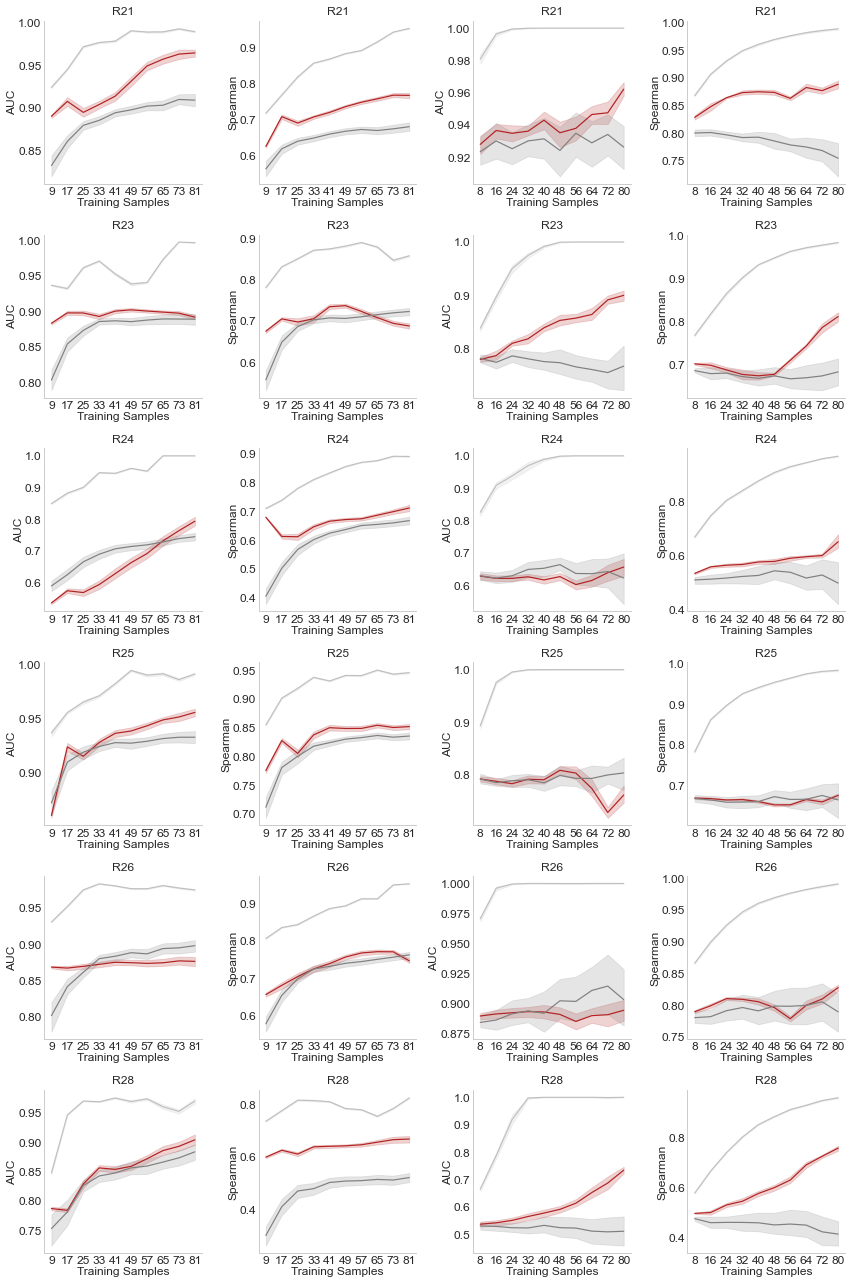

In [21]:
n_cols = 4
n_rows = 6
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols * 3, n_rows * 3))


for i, tcr in enumerate(['R21', 'R23', 'R24', 'R25', 'R26', 'R28']):
    for j, mode in enumerate([results_within_human, results_across_human]):
        res_methods = {}
        for method, method_dict in mode.items():
            res_metric = {}
            for metric, metric_dict in method_dict.items():
                res = [el for el in metric_dict if el[0]==tcr]
                res_metric[metric] = res
            res_methods[method] = res_metric
        
        if mode == results_within_human:
            xticks = [9+8*i for i in range(10)]
        else:
            xticks = [8+8*i for i in range(10)]
        #print(res_methods)
        plot_performance(res_methods, 'auc', ['Active', 'Random', 'Greedy_auc'], ax=axes[i][j*2], xticks=xticks, 
                         active_color=color_human)
        axes[i][j*2].set_title(tcr)
        plot_performance(res_methods, 'Spearman', ['Active', 'Random', 'Greedy_spearman'], ax=axes[i][j*2+1], xticks=xticks, 
                         active_color=color_human)
        axes[i][j*2+1].set_title(tcr)
        
plt.tight_layout()
plt.show()

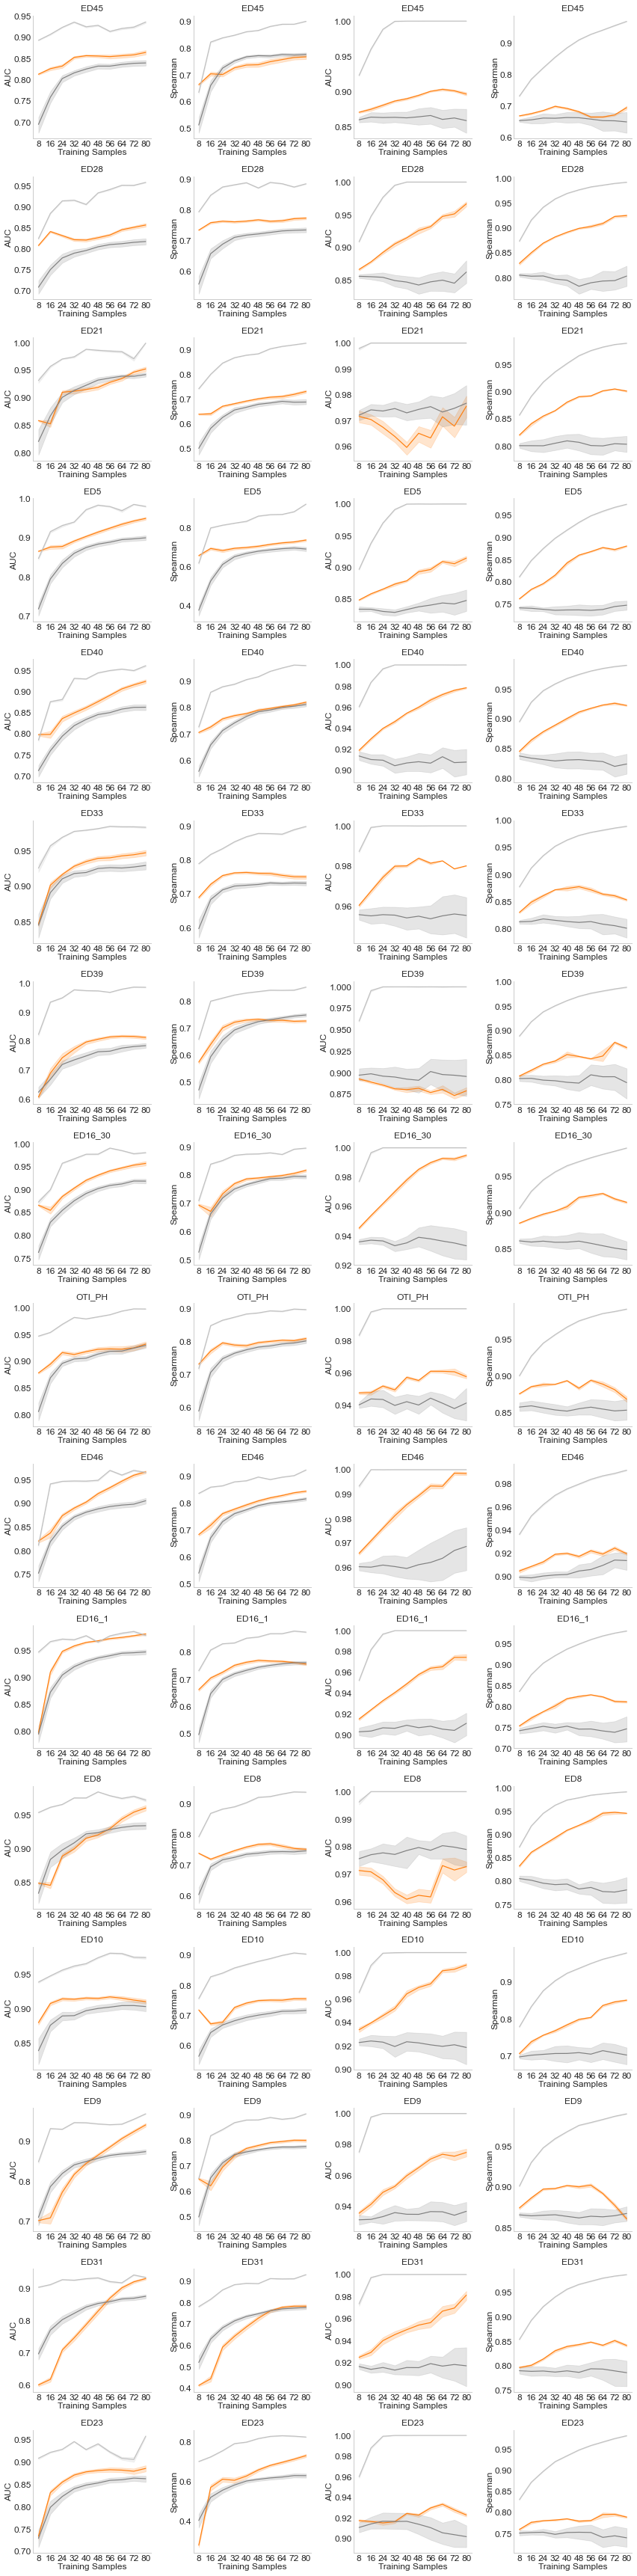

In [22]:
tcrs = list(set([el[0] for el in results_within_mice['Active']['MAE']]))

n_cols = 4
n_rows = len(tcrs)
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols * 3, n_rows * 3))

for i, tcr in enumerate(tcrs):
    for j, mode in enumerate([results_within_mice, results_across_mice]):
        res_methods = {}
        for method, method_dict in mode.items():
            res_metric = {}
            for metric, metric_dict in method_dict.items():
                res = [el for el in metric_dict if el[0]==tcr]
                res_metric[metric] = res
            res_methods[method] = res_metric
        
        if mode == results_within_human:
            xticks = [9+8*i for i in range(10)]
        else:
            xticks = [8+8*i for i in range(10)]
        plot_performance(res_methods, 'auc', ['Active', 'Random', 'Greedy_auc'], ax=axes[i][j*2], xticks=xticks)
        axes[i][j*2].set_title(tcr)
        plot_performance(res_methods, 'Spearman', ['Active', 'Random', 'Greedy_spearman'], ax=axes[i][j*2+1], xticks=xticks)
        axes[i][j*2+1].set_title(tcr)
        
plt.tight_layout()
plt.show()